Training with batch size 64
Epoch [1/30], Train Loss: 0.3741, Train Acc: 0.8850, Test Loss: 0.3004, Test Acc: 0.9112, Sensitivity: 0.4668
Epoch [2/30], Train Loss: 0.2524, Train Acc: 0.9280, Test Loss: 0.2609, Test Acc: 0.9280, Sensitivity: 0.3568
Epoch [3/30], Train Loss: 0.2280, Train Acc: 0.9350, Test Loss: 0.2328, Test Acc: 0.9370, Sensitivity: 0.3230
Epoch [4/30], Train Loss: 0.2191, Train Acc: 0.9387, Test Loss: 0.2084, Test Acc: 0.9444, Sensitivity: 0.3192
Epoch [5/30], Train Loss: 0.2137, Train Acc: 0.9403, Test Loss: 0.2809, Test Acc: 0.9209, Sensitivity: 0.3173
Epoch [6/30], Train Loss: 0.2111, Train Acc: 0.9417, Test Loss: 0.2094, Test Acc: 0.9441, Sensitivity: 0.3167
Epoch [7/30], Train Loss: 0.2080, Train Acc: 0.9439, Test Loss: 0.2073, Test Acc: 0.9448, Sensitivity: 0.3115
Epoch [8/30], Train Loss: 0.2051, Train Acc: 0.9461, Test Loss: 0.2096, Test Acc: 0.9468, Sensitivity: 0.3091
Epoch [9/30], Train Loss: 0.1972, Train Acc: 0.9465, Test Loss: 0.2273, Test Acc: 0.9413, Se

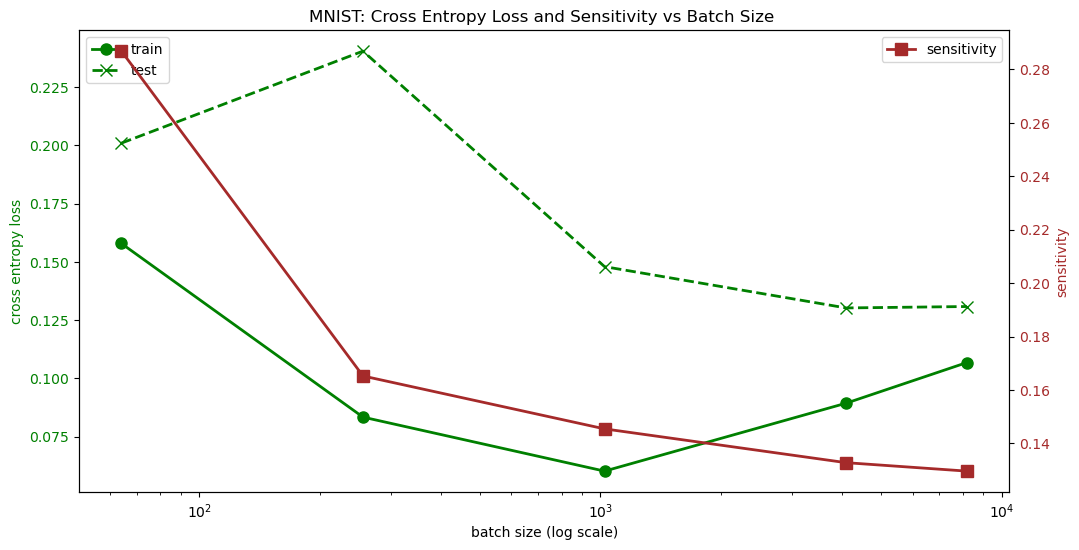

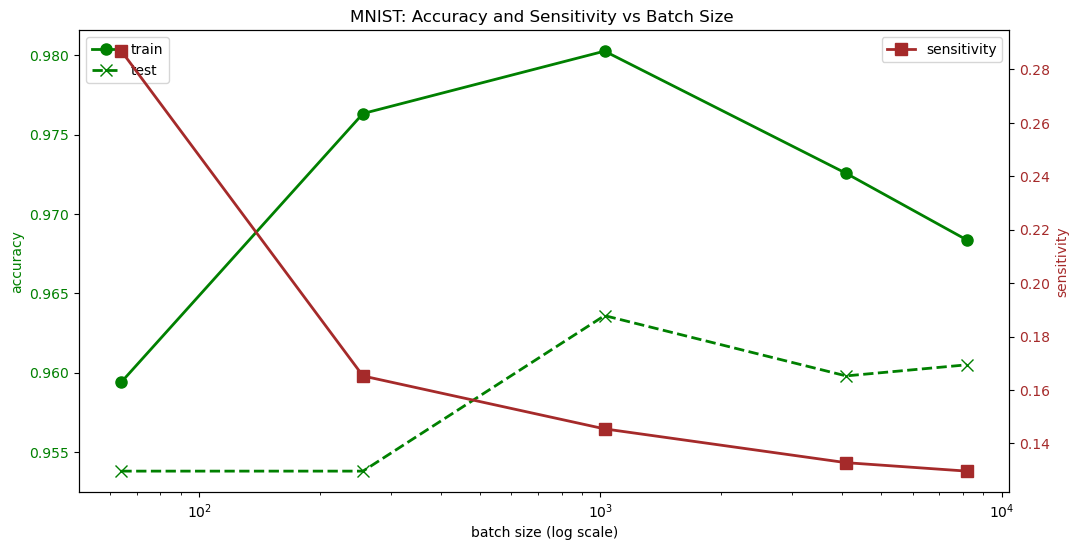

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Load MNIST dataset
data_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=data_transforms)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=data_transforms)

batch_sizes = [64, 256, 1024, 4096, 8192]
train_loaders = {bs: DataLoader(train_data, batch_size=bs, shuffle=True) for bs in batch_sizes}
test_loaders = {bs: DataLoader(test_data, batch_size=bs, shuffle=False) for bs in batch_sizes}


compute_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  # Input to hidden layer
        self.fc2 = nn.Linear(128, 64)  # Hidden layer 1 to hidden layer 2
        self.fc3 = nn.Linear(64, 10)  # Hidden layer to output

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Function to compute the Frobenius norm of gradients
def compute_sensitivity(model):
    frobenius_norm = 0.0
    grad_count = 0
    for param in model.parameters():
        if param.grad is not None:
            fro_norm = torch.linalg.norm(param.grad).item()
            frobenius_norm += fro_norm
            grad_count += 1
    if grad_count > 0:
        return frobenius_norm / grad_count
    return 0.0

# Function to train and evaluate the model
def run_training_session(model, train_loader, test_loader, optimizer, criterion, num_epochs, device):
    train_losses, train_acc, test_losses, test_acc, sens_values = [], [], [], [], []

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        correct_train, total_train, grad_norm = 0, 0, 0.0

        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            predictions = model(data)
            loss = criterion(predictions, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Compute train metrics
            epoch_train_loss += loss.item() * data.size(0)
            _, pred_labels = torch.max(predictions, 1)
            correct_train += (pred_labels == labels).sum().item()
            total_train += labels.size(0)

            # Compute gradient norm
            grad_norm += compute_sensitivity(model)

        # Average training loss and accuracy
        avg_train_loss = epoch_train_loss / len(train_loader.dataset)
        avg_train_acc = correct_train / total_train
        avg_sensitivity = grad_norm / len(train_loader)

        # Testing phase
        model.eval()
        correct_test, total_test, test_loss_sum = 0, 0, 0.0
        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)
                predictions = model(data)
                test_loss = criterion(predictions, labels)
                test_loss_sum += test_loss.item() * data.size(0)
                _, pred_test_labels = torch.max(predictions, 1)
                correct_test += (pred_test_labels == labels).sum().item()
                total_test += labels.size(0)

        # Average test loss and accuracy
        avg_test_loss = test_loss_sum / len(test_loader.dataset)
        avg_test_acc = correct_test / total_test

        # Store metrics for this epoch
        train_losses.append(avg_train_loss)
        train_acc.append(avg_train_acc)
        test_losses.append(avg_test_loss)
        test_acc.append(avg_test_acc)
        sens_values.append(avg_sensitivity)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, Test Loss: {avg_test_loss:.4f}, Test Acc: {avg_test_acc:.4f}, Sensitivity: {avg_sensitivity:.4f}")

    return train_losses, train_acc, test_losses, test_acc, sens_values

# Criterion and optimizer
loss_fn = nn.CrossEntropyLoss()

# Collecting results for different batch sizes
results = {}

for bs in batch_sizes:
    model_instance = MLPModel().to(compute_device)
    optimizer_instance = optim.Adam(model_instance.parameters(), lr=0.01)
    print(f"Training with batch size {bs}")
    train_loader = train_loaders[bs]
    test_loader = test_loaders[bs]
    results[bs] = run_training_session(model_instance, train_loader, test_loader, optimizer_instance, loss_fn, 30, compute_device)

# Extract final results
train_loss_final = [results[bs][0][-1] for bs in batch_sizes]
test_loss_final = [results[bs][2][-1] for bs in batch_sizes]
train_acc_final = [results[bs][1][-1] for bs in batch_sizes]
test_acc_final = [results[bs][3][-1] for bs in batch_sizes]
sens_final = [results[bs][4][-1] for bs in batch_sizes]

# Convert batch sizes to log scale
log_batch_sizes = [torch.log10(torch.tensor(bs)).item() for bs in batch_sizes]

# Plotting Loss and Sensitivity vs Batch Size 
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('batch size (log scale)')
ax1.set_xscale('log')
ax1.set_ylabel('cross entropy loss', color='green')
ax1.plot(batch_sizes, train_loss_final, label='train', color='green', linestyle='-', marker='o', markersize=8, linewidth=2)
ax1.plot(batch_sizes, test_loss_final, label='test', color='green', linestyle='--', marker='x', markersize=8, linewidth=2)
ax1.tick_params(axis='y', labelcolor='green')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
ax2.set_ylabel('sensitivity', color='brown')  
ax2.plot(batch_sizes, sens_final, label='sensitivity', color='brown', linestyle='-', marker='s', markersize=8, linewidth=2)
ax2.tick_params(axis='y', labelcolor='brown')
ax2.legend(loc='upper right')

plt.title('MNIST: Cross Entropy Loss and Sensitivity vs Batch Size ')

plt.show()

# Plotting Accuracy and Sensitivity vs Batch Size 
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('batch size (log scale)')
ax1.set_xscale('log')
ax1.set_ylabel('accuracy', color='green')
ax1.plot(batch_sizes, train_acc_final, label='train', color='green', linestyle='-', marker='o', markersize=8, linewidth=2)
ax1.plot(batch_sizes, test_acc_final, label='test', color='green', linestyle='--', marker='x', markersize=8, linewidth=2)
ax1.tick_params(axis='y', labelcolor='green')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
ax2.set_ylabel('sensitivity', color='brown')  
ax2.plot(batch_sizes, sens_final, label='sensitivity', color='brown', linestyle='-', marker='s', markersize=8, linewidth=2)
ax2.tick_params(axis='y', labelcolor='brown')
ax2.legend(loc='upper right')

plt.title('MNIST: Accuracy and Sensitivity vs Batch Size ')

plt.show()
